<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/clusters.png" width="400px"></div>

# Clustering: Picking the 'K' hyperparameter
The unsupervised machine learning technique of clustering data into similar groups can be useful and fairly efficient in most cases. The big trick is often how you pick the number of clusters to make (the K hyperparameter). 
The number of clusters may vary dramatically depending on the characteristics of the data, the different types of variables (numeric or categorical), how the data is normalized/encoded and the distance metric used.

<div style="float: left; margin: 20px 50px 20px 20px"><img src="images/picking.png" width="100px"></div>
**For this notebook we're going to focus specifically on the following:**
- Optimizing the number of clusters (K hyperparameter) using Silhouette Scoring
- Utilizing an algorithm (DBSCAN) that automatically determines the number of clusters


### Software
- BroThon: https://github.com/Kitware/BroThon
- Pandas: https://github.com/pandas-dev/pandas
- Scikit-Learn: http://scikit-learn.org/stable/index.html

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/scikit.png" width="200px"></div>
### Techniques
- One Hot Encoding: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
- PCA: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Kmeans: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- Silhouette Score: https://en.wikipedia.org/wiki/Silhouette_(clustering)
- DBSCAN: https://en.wikipedia.org/wiki/DBSCAN

In [10]:
%%bash
pip3 install brothon pandas scikit-learn girder-client

  Using cached brothon-0.2.5-py2.py3-none-any.whl
  Using cached requests-2.18.4-py2.py3-none-any.whl
  Using cached watchdog-0.8.3.tar.gz
  Using cached python_dateutil-2.6.1-py2.py3-none-any.whl
  Using cached pytz-2017.2-py2.py3-none-any.whl
  Using cached chardet-3.0.4-py2.py3-none-any.whl
  Using cached idna-2.6-py2.py3-none-any.whl
  Using cached certifi-2017.7.27.1-py2.py3-none-any.whl
  Using cached urllib3-1.22-py2.py3-none-any.whl
  Using cached PyYAML-3.12.tar.gz
  Using cached argh-0.26.2-py2.py3-none-any.whl
  Using cached pathtools-0.1.2.tar.gz
  Using cached six-1.10.0-py2.py3-none-any.whl
  Running setup.py bdist_wheel for watchdog: started
  Running setup.py bdist_wheel for watchdog: finished with status 'done'
  Stored in directory: /home/girder/.cache/pip/wheels/3c/9c/be/e82ae5a37c19baf8abe88623d1f47d2d502bed7b54d4f34740
  Running setup.py bdist_wheel for PyYAML: started
  Running setup.py bdist_wheel for PyYAML: finished with status 'done'
  Stored in directory: /ho

You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
# Third Party Imports
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans, DBSCAN

# Local imports
import brothon
from brothon import bro_log_reader
from brothon.analysis import dataframe_to_matrix

# Good to print out versions of stuff
print('BroThon: {:s}'.format(brothon.__version__))
print('Pandas: {:s}'.format(pd.__version__))
print('Scikit Learn Version:', sklearn.__version__)

ImportError: No module named 'pandas'

# Pull data from the Girder Data Management Platform

The most basic level of integration with Girder can happen directly inside your jupyter notebook -- you can use the [Girder python client library](http://girder.readthedocs.io/en/latest/python-client.html). Rather than referring to a file on the local filesystem as you normally would, you can instead point to data in Girder and download it locally. This makes your jupyter notebook portable, since it can dynamically fetch its own inputs.

In [204]:
import girder_client

# Create a Grider Client handle
gc = girder_client.GirderClient(apiUrl='https://talonw4.afrl.hpc.mil/api/v1')

# Give Girder our DoDRoot cert
with gc.session() as session:
    session.verify = './DoDRoot3.pem'

    # Authenticate through HTTPS with our API Key
    gc.authenticate(apiKey='isZW9ijxDPoOYn2vNmgbsfD84zaO6dxs9lyqQ3fl')
    
    # Now that we have an active girder connection we can look at available data and pull some down
    
    # TODO: Fix this
    # print(list(gc.listResource('/collections')))
    gc.downloadItem(itemId='5942de7caefb0b0e98409a1e', dest='.', name='http.log')

In [205]:
# Load in the Bro IDS dns logs
reader = bro_log_reader.BroLogReader('http.log')

# Create a Pandas dataframe from reader
http_df = pd.DataFrame(reader.readrows())

# Print out the head of the dataframe
http_df.head()

Successfully monitoring http.log...


,filename,host,id.orig_h,id.orig_p,id.resp_h,id.resp_p,info_code,info_msg,method,orig_fuids,...,response_body_len,status_code,status_msg,tags,trans_depth,ts,uid,uri,user_agent,username
0,-,guyspy.com,192.168.33.10,1031,54.245.228.191,80,-,-,GET,-,...,184,301,Moved Permanently,(empty),1,2013-09-15 17:44:27.668082,CyIaMO7IheOh38Zsi,/,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-
1,-,www.guyspy.com,192.168.33.10,1032,54.245.228.191,80,-,-,GET,-,...,100631,200,OK,(empty),1,2013-09-15 17:44:27.731702,CoyZrY2g74UvMMgp4a,/,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-
2,-,www.guyspy.com,192.168.33.10,1032,54.245.228.191,80,-,-,GET,-,...,55817,404,Not Found,(empty),2,2013-09-15 17:44:28.092922,CoyZrY2g74UvMMgp4a,/wp-content/plugins/slider-pro/css/advanced-sl...,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-
3,-,www.guyspy.com,192.168.33.10,1040,54.245.228.191,80,-,-,GET,-,...,887,200,OK,(empty),1,2013-09-15 17:44:28.150301,CiCKTz4e0fkYYazBS3,/wp-content/plugins/contact-form-7/includes/cs...,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-
4,-,www.guyspy.com,192.168.33.10,1041,54.245.228.191,80,-,-,GET,-,...,10068,200,OK,(empty),1,2013-09-15 17:44:28.150602,C1YBkC1uuO9bzndRvh,/wp-content/plugins/slider-pro/css/slider/adva...,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,-


# Our HTTP features are a mix of numeric and categorical data
When we look at the http records some of the data is numerical and some of it is categorical so we'll need a way of handling both data types in a generalized way. We have a DataFrameToMatrix class that handles a lot of the details and mechanics of combining numerical and categorical data, we'll use below.

<div style="float: right; margin: 10px 40px 10px 40px"><img src="images/transformers.png" width="200px"></div>
## Transformers
**We'll now use the Scikit-Learn tranformer class to convert the Pandas DataFrame to a numpy ndarray (matrix). The transformer class takes care of many low-level details**
* Applies 'one-hot' encoding for the Categorical fields
* Normalizes the Numeric fields
* The class can be serialized for use in training and evaluation
  * The categorical mappings are saved during training and applied at evaluation
  * The normalized field ranges are stored during training and applied at evaluation

In [206]:
# We're going to pick some features that might be interesting
# some of the features are numerical and some are categorical
features = ['id.resp_p', 'method', 'resp_mime_types', 'request_body_len']

# Use the DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = dataframe_to_matrix.DataFrameToMatrix()
http_feature_matrix = to_matrix.fit_transform(http_df[features], normalize=True)

print('\nNOTE: The resulting numpy matrix has 12 dimensions based on one-hot encoding')
print(http_feature_matrix.shape)
http_feature_matrix[:1]

Changing column method to category...
Changing column resp_mime_types to category...
Normalizing column id.resp_p...
Normalizing column request_body_len...

NOTE: The resulting numpy matrix has 12 dimensions based on one-hot encoding
(150, 12)


array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]])

In [207]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 14.0, 7.0

# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

<div style="float: right; margin: 10px 40px 10px 40px"><img src="images/silhouette.jpg" width="250px"></div>
# Silhouette Scoring
"The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters."
- https://en.wikipedia.org/wiki/Silhouette_(clustering)

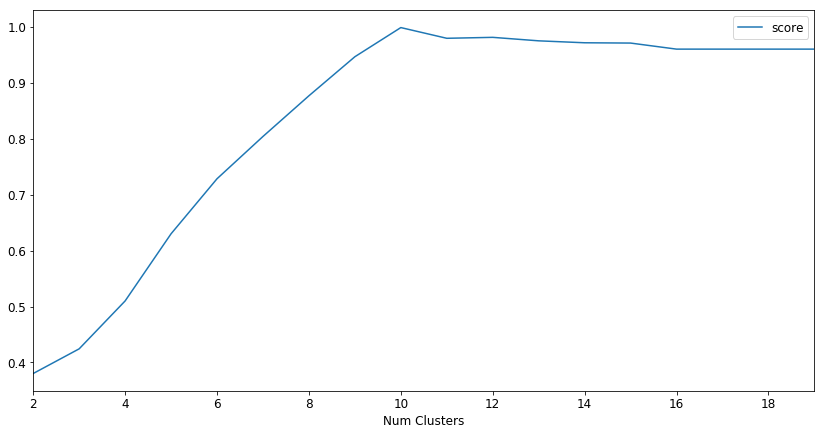

In [221]:
from sklearn.metrics import silhouette_score

scores = []
clusters = range(2,20)
for K in clusters:
    
    clusterer = KMeans(n_clusters=K)
    cluster_labels = clusterer.fit_predict(http_feature_matrix)
    score = silhouette_score(http_feature_matrix, cluster_labels)
    scores.append(score)

# Plot it out
pd.DataFrame({'Num Clusters':clusters, 'score':scores}).plot(x='Num Clusters', y='score')

## Silhouette graphs shows that 10 is the 'optimal' number of clusters
- 'Optimal': Human intuition and clustering involves interpretation/pattern finding and is often partially subjective :)
- For large datasets running an exhaustive search can be time consuming
- For large datasets you can often get a large K using max score, so pick the 'knee' of the graph as your K

In [210]:
# So we know that the highest (closest to 1) silhouette score is at 10 clusters
kmeans = KMeans(n_clusters=10).fit_predict(http_feature_matrix)
pca = PCA(n_components=5).fit_transform(http_feature_matrix)

# Now we can put our ML results back onto our dataframe!
http_df['cluster'] = kmeans

# This is just a HACK for displaying 12 dimensional data in 2D
http_df['x'] = pca[:, 0] + pca[:, 2]             # Combining the first and third principle components 
http_df['y'] = pca[:, 1] + pca[:, 3] + pca[:, 4] # Combining the rest of the principle components

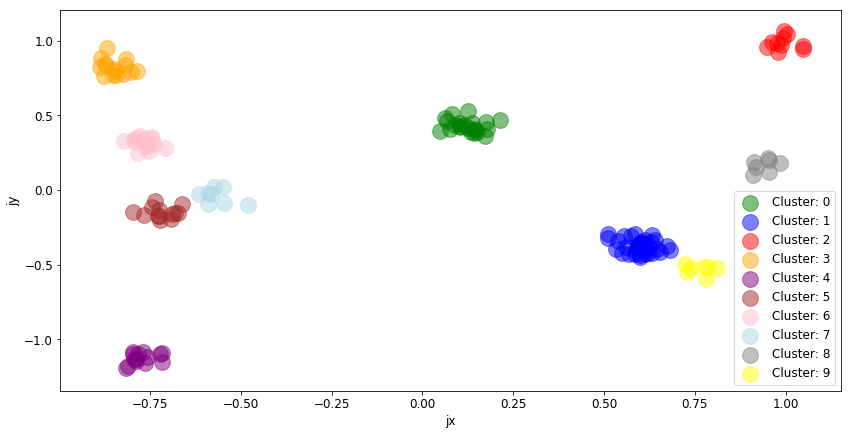

In [212]:
# Jitter so we can see instances that are projected coincident in 2D
http_df['jx'] = jitter(http_df['x'])
http_df['jy'] = jitter(http_df['y'])

# Now use dataframe group by cluster
cluster_groups = http_df.groupby('cluster')

# Plot the Machine Learning results
colors = {-1:'black', 0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown', 6:'pink', 7:'lightblue', 8:'grey', 9:'yellow'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [213]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 22 observations
    id.resp_p method resp_mime_types  request_body_len
22         80    GET      image/jpeg                 0
24         80    GET      image/jpeg                 0
29         80    GET      image/jpeg                 0
30         80    GET      image/jpeg                 0
32         80    GET      image/jpeg                 0

Cluster 1: 40 observations
   id.resp_p method resp_mime_types  request_body_len
3         80    GET      text/plain                 0
4         80    GET      text/plain                 0
6         80    GET      text/plain                 0
7         80    GET      text/plain                 0
8         80    GET      text/plain                 0

Cluster 2: 10 observations
     id.resp_p method resp_mime_types  request_body_len
140         80   POST      text/plain             69823
141         80   POST      text/plain             69993
142         80   POST      text/plain             71993
143         80   POST      text/plain 

<div style="float: right; margin: 10px 40px 10px 40px"><img src="images/no_hands.jpg" width="350px"></div>
# Look Ma... No K!
### DBSCAN
Density-based spatial clustering is a data clustering algorithm that given a set of points in space, groups points that are closely packed together and marking low-density regions as outliers.

- You don't have to pick K
- There are other hyperparameters (eps and min_samples) but defaults often work well
- https://en.wikipedia.org/wiki/DBSCAN
- Hierarchical version: https://github.com/scikit-learn-contrib/hdbscan

In [214]:
# Now try DBScan
http_df['cluster_db'] = DBSCAN().fit_predict(http_feature_matrix)

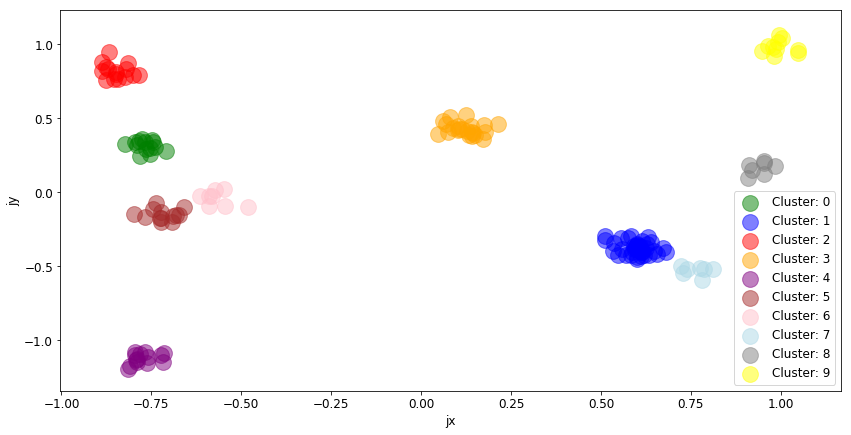

In [215]:
# Now use dataframe group by cluster
cluster_groups = http_df.groupby('cluster_db')

# Plot the Machine Learning results
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [216]:
# Now try DBScan with different parameters
http_df['cluster_db'] = DBSCAN(min_samples=10).fit_predict(http_feature_matrix)

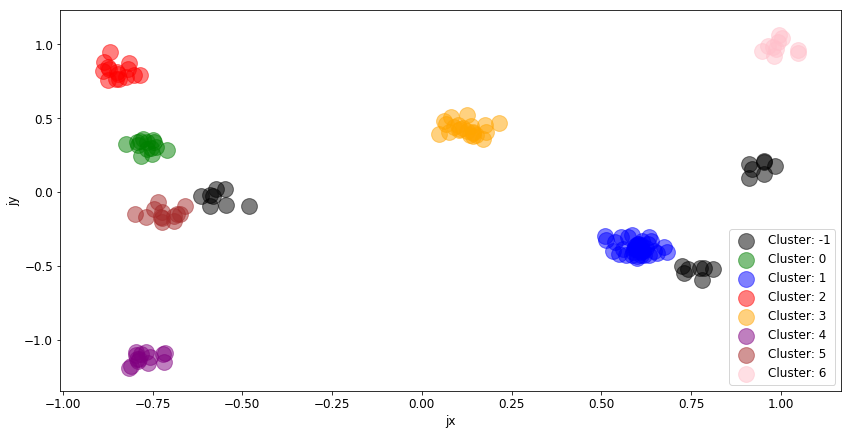

In [217]:
# Now use dataframe group by cluster
cluster_groups = http_df.groupby('cluster_db')

# Plot the Machine Learning results
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])